# Kinetic Free energy for Hydrogen

Here we solve the Schrodinger equation for the Hydrogen Atom

The integral form of the Schrodinger equation is

\begin{align*}
\tilde{\phi}^{n+1} = -2 \hat{H}^{\mu^n}[V \phi^n]
\end{align*}

where $\hat{H}$ is the Helmholtz operator, $\mu = \sqrt{-2E}$


In [1]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Analytic nuclear potential
def nuclear_potential(r):
    R = np.sqrt(r[0]*r[0] + r[1]*r[1] + r[2]*r[2])
    return -1.0 / R

# Analytic guess for solution
def phi_0(r):
    R = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
    return np.exp(-R**2)



# Define MRA and multiwavelet projector
precision = 1.0e-5          # Relative precision
MRA = vp.MultiResolutionAnalysis(order=7, box=[-20, 20])
projection_operator = vp.ScalingProjector(mra=MRA, prec=precision)

# Project analytic nuclear potential
V_nuc = projection_operator(nuclear_potential)

# Initial guess for the wavefunction
phi_n = projection_operator(phi_0)
phi_n.normalize()

# Prepare Helmholtz operator
E = -1.0
mu = np.sqrt(-2*E)
H = vp.HelmholtzOperator(mra=MRA, exp=mu, prec=precision)
    
# Minimization loop
thrs = precision*10.0
update = 1.0
energies = []
updates = []
while (update > thrs):
    # Apply Helmholtz operator
    Vphi = V_nuc * phi_n
    phi_np1 = -2*H(Vphi)
    norm = phi_np1.norm()
    
    # Compute orbital and energy updates
    dPhi_n = phi_np1 - phi_n
    E += vp.dot(phi_np1, V_nuc*(phi_np1-phi_n))
    H = vp.HelmholtzOperator(mra=MRA, exp=np.sqrt(-2.0*E), prec=precision)
    update = dPhi_n.norm()
    
    # Prepare for next iteration
    phi_n = phi_np1
    phi_n.normalize()
    phi_n.crop(precision)  # Truncate MW exansion based on precision
    energies.append(E)
    updates.append(update)
    print("E", E, "update", update)



E -0.6714736965012144 update 0.35065446088509555
E -0.48032762789570405 update 0.18516164815637226
E -0.4898573009945606 update 0.17596108214955625
E -0.49842645340155434 update 0.08095319495400322
E -0.4995108727426518 update 0.033705674063184574
E -0.49988068098254745 update 0.01614358666660803
E -0.4999699485982093 update 0.0078453357996729
E -0.49999234208326704 update 0.0038771549532199815
E -0.49999794118683344 update 0.001929884195601873
E -0.4999993409454721 update 0.0009636624348922643
E -0.49999969083264395 update 0.0004818061155016507
E -0.4999997783010367 update 0.0002409945145380358
E -0.499999800167894 update 0.00012055257355518954
E -0.4999998056344627 update 6.0300900111083584e-05


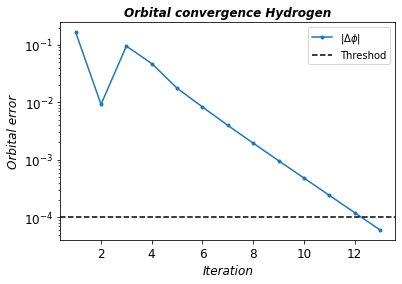

In [13]:
updates_df = pd.DataFrame({"$\phi$":updates})
updates_df["$|\Delta \phi|$"] = updates_df.diff().abs()
updates_df.plot(y="$|\Delta \phi|$", logy=True, style=".-")
plt.title("Orbital convergence Hydrogen", fontstyle="italic", fontsize=12,fontweight='bold')
plt.xlabel("Iteration", fontstyle="italic", fontsize=12)
plt.ylabel("Orbital error", fontstyle="italic", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.axhline(precision*10, linestyle="--", color="black", label="Threshod")
plt.legend()
plt.show()

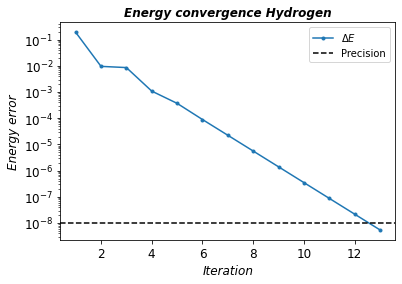

In [16]:
energies_df = pd.DataFrame({"$E$":energies})
energies_df["$\Delta E$"] = energies_df.diff().abs()
energies_df["$\Delta E$"].plot(logy=True, style=".-")
plt.title("Energy convergence Hydrogen", fontstyle="italic", fontsize=12,fontweight='bold')
plt.xlabel("Iteration", fontstyle="italic", fontsize=12)
plt.ylabel("Energy error", fontstyle="italic", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.axhline(1.0e-8, linestyle="--", color="black", label="Precision")
plt.legend()
plt.savefig("energy_prec8.png", transparent=True, bbox_inches="tight")
plt.show()
